In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [38]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
# Save references to each table
Measure=Base.classes.measurement
Station=Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [42]:
# Find the most recent date in the data set.
import datetime as dt
newest = session.query(Measure.date).order_by(Measure.date.desc()).first()
newest = newest[0]
newest

'2017-08-23'

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the newest date in dataset.
yr_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
yr_prior

datetime.date(2016, 8, 23)

In [45]:
# Perform a query to retrieve the data and precipitation scores
# Find all of the dates greater than `2016-08-23`
yr_prior_dt = dt.date(2016, 8, 23)
qdata = session.query(Measure.date, Measure.station, Measure.prcp, Measure.tobs).filter(Measure.date > yr_prior_dt).all()
qdata

[('2016-08-24', 'USC00519397', 0.08, 79.0),
 ('2016-08-25', 'USC00519397', 0.08, 80.0),
 ('2016-08-26', 'USC00519397', 0.0, 79.0),
 ('2016-08-27', 'USC00519397', 0.0, 77.0),
 ('2016-08-28', 'USC00519397', 0.01, 78.0),
 ('2016-08-29', 'USC00519397', 0.0, 78.0),
 ('2016-08-30', 'USC00519397', 0.0, 79.0),
 ('2016-08-31', 'USC00519397', 0.13, 80.0),
 ('2016-09-01', 'USC00519397', 0.0, 81.0),
 ('2016-09-02', 'USC00519397', 0.0, 80.0),
 ('2016-09-03', 'USC00519397', 0.0, 79.0),
 ('2016-09-04', 'USC00519397', 0.03, 75.0),
 ('2016-09-05', 'USC00519397', None, 79.0),
 ('2016-09-06', 'USC00519397', None, 76.0),
 ('2016-09-07', 'USC00519397', 0.05, 76.0),
 ('2016-09-08', 'USC00519397', 0.0, 80.0),
 ('2016-09-09', 'USC00519397', 0.03, 79.0),
 ('2016-09-10', 'USC00519397', 0.0, 78.0),
 ('2016-09-11', 'USC00519397', 0.05, 76.0),
 ('2016-09-12', 'USC00519397', 0.0, 78.0),
 ('2016-09-13', 'USC00519397', 0.02, 78.0),
 ('2016-09-14', 'USC00519397', 1.32, 75.0),
 ('2016-09-15', 'USC00519397', 0.42, 79.0)

In [46]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
qdata_df = pd.DataFrame(qdata, columns=['date', 'station', 'prcp', 'tobs'])

# Sort the dataframe by date
qdata_df = qdata_df.sort_values("date")

# Filter out all rows with a prcp value of "none".
qdata_df = qdata_df.dropna(subset=['prcp'])

# Reset the index (x-axis) to the 'date' column.
qdata_df = qdata_df.reset_index(drop=True)
qdata_df.head(50)


,date,station,prcp,tobs
0,2016-08-24,USC00519397,0.08,79.0
1,2016-08-24,USC00519281,2.15,77.0
2,2016-08-24,USC00514830,2.28,80.0
3,2016-08-24,USC00513117,2.15,76.0
4,2016-08-24,USC00516128,1.45,74.0
5,2016-08-24,USC00519523,1.22,79.0
6,2016-08-25,USC00519397,0.08,80.0
7,2016-08-25,USC00517948,0.00,81.0
8,2016-08-25,USC00519281,0.06,80.0
9,2016-08-25,USC00514830,0.00,81.0


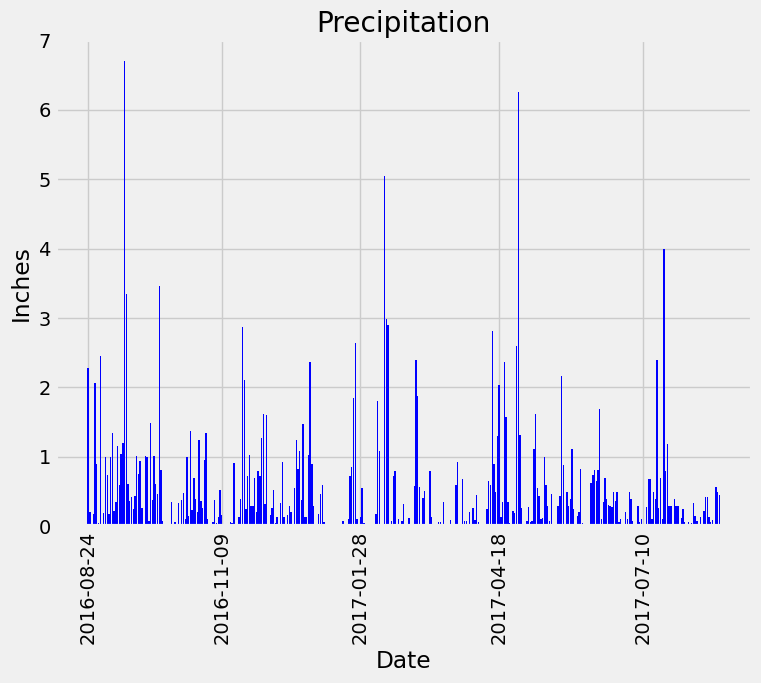

In [54]:
# Use Pandas Plotting with Matplotlib to plot the data
# Extract the date and prcp columns
dates = qdata_df['date']
prcp = qdata_df['prcp']

# Set the size of the figure
plt.figure(figsize=(8, 6))

# Plot the bar graph
plt.bar(dates, prcp, color="b", linewidth=12)

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation')

# Specify the axis values and labels
x_ticks = ['2016-08-24', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(x_ticks, rotation="vertical")
plt.ylim(0, 7)

# Display the plot.
plt.show()

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = qdata_df['prcp'].describe().to_frame().rename(columns={'prcp': 'precipitation'})
summary_stats.head(20)


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()